In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGen, AffineGridGen, AffineGridGenV2, DenseAffineGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

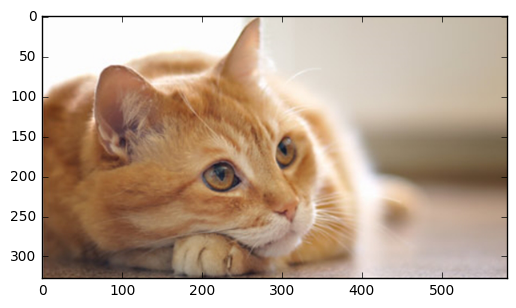

In [2]:
img = Image.open('cat.jpg').convert('RGB')
img = np.array(img)/255.0
plt.imshow(img)

In [3]:
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
inputImages.size()
s = STN()
g = AffineGridGenV2(328, 582)
input = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)), requires_grad = True)
#print input
aux_zeros = Variable(torch.zeros(1))
out = g(input)
grid_out = out # save for later use
input1 = Variable(inputImages)
res = s(input1, out)
res = res.data.numpy()

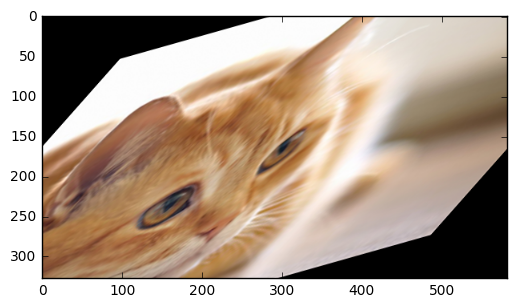

In [4]:
plt.imshow(res[0])

In [5]:
target = Variable(torch.from_numpy(res))

In [6]:
print input1.size(), target.size()

torch.Size([1, 328, 582, 3]) torch.Size([1, 328, 582, 3])


In [7]:
crt = nn.L1Loss()
crt2 = nn.L1Loss()

In [8]:
crt.forward(input1, target)

Variable containing:
 0.2754
[torch.FloatTensor of size 1]

In [9]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.s = STN()
        self.g = AffineGridGenV2(328, 582, lr = 0.01)
    def forward(self,input1, input2):
        out = self.g(input2)
        out2 = self.s(input1, out)
        return out2

In [10]:
t = Transformer()

In [11]:
x = np.arange(0.1, 2, 0.01)
y = []
g_ = []
for v in x:
    input2 = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.48, v, 0]]], dtype=np.float32)) , requires_grad = True)
    out  = t(input1, input2)
    err = crt(out, target)
    err.backward()
    y.append(err.data[0])
    #print input2.grad.size()
    g_.append(input2.grad.data[0,1,1])


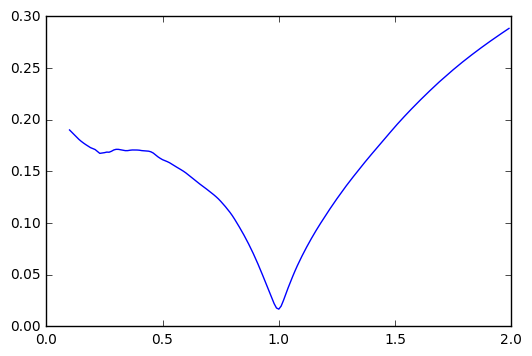

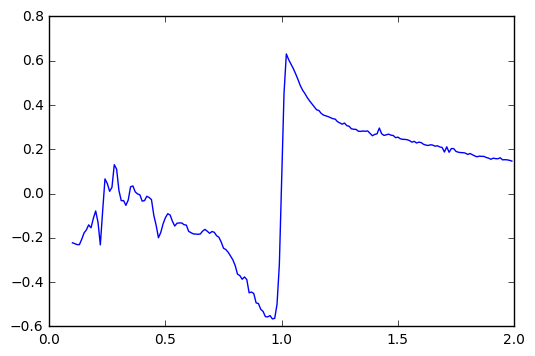

In [12]:
plt.figure()
plt.plot(x,y)
plt.figure()
plt.plot(x,g_)

In [22]:
class ConvSpatialTransformer(nn.Module):
    def __init__(self,  height, width):
        super(ConvSpatialTransformer, self).__init__()
        self.s = STN()
        self.conv = nn.Sequential( 
            torch.nn.Conv2d(3, 6, 3, stride=1, padding=1),
            torch.nn.Conv2d(6, 6, 3, stride=1, padding=1),
            torch.nn.Conv2d(6, 6, 3, stride=1, padding=1),
            torch.nn.Conv2d(6, 6, 3, stride=1, padding=1),
        ).cuda()
        self.g = DenseAffineGridGen(height, width).cuda()
    def forward(self,input1, input2):
        conv = self.conv(input2.transpose(2,3).transpose(1,2))
        conv = conv.transpose(1,2).transpose(2,3)
        iden = Variable(torch.cat([torch.ones(1, 328, 582, 1), torch.zeros(1, 328, 582, 3), torch.ones(1, 328, 582, 1), torch.zeros(1, 328, 582, 1)],3 ))
        
        iden = iden.cuda()
        
        print conv.size(), iden.size()
        out = self.g(conv + iden)
        out2 = self.s(input1, out.cpu())
        return out2, out

In [23]:
c = ConvSpatialTransformer(328, 582)
input2 = input1.clone()

In [24]:
res, grid = c(input1, input2.cuda())

torch.Size([1, 328, 582, 6]) torch.Size([1, 328, 582, 6])


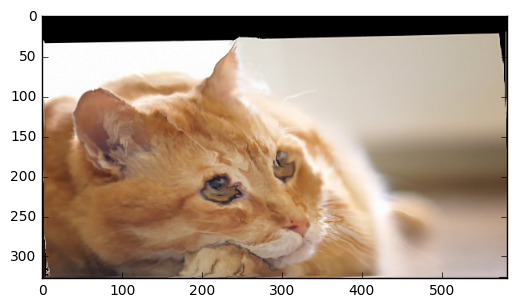

In [25]:
plt.imshow(res.data.numpy()[0])

In [29]:
grid = grid.cpu().data.numpy()[0]

In [30]:
delta = 0.025
x = np.arange(-1, 1, 2/582.0)
y = np.arange(-1, 1, 2/328.0)
X, Y = np.meshgrid(x, y)
Z1 = grid[:,:,0]
Z2 = grid[:,:,1]

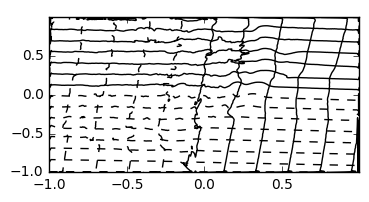

In [31]:
fig = plt.figure(figsize=(4,2))
CS = plt.contour(X, Y, Z1, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
CS = plt.contour(X, Y, Z2, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)

In [32]:
fig.canvas.draw()

# Now we can save it to a numpy array.
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

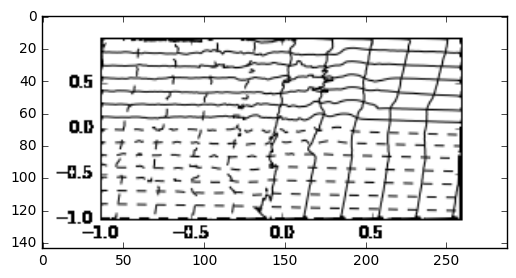

In [33]:
plt.imshow(data)